In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure
from sklearn.tree import plot_tree
# For the models
from sklearn.metrics import log_loss
from sklearn.tree import DecisionTreeClassifier, export_graphviz

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
df = pd.read_csv("finalDataPerAttack.csv")
df.drop(columns='Unnamed: 0', inplace=True)
df.head()

,Key,time,dis,TopSpeed,maxAngle,BodyPart,FieldType,RosterPosition,PlayType
0,31070-1-1,29.5,2.85,5.30,32.43,health,Natural,Running Back,Punt
1,31070-1-2,60.6,9.14,6.29,100.55,health,Natural,Running Back,Pass
2,31070-1-3,42.0,6.25,5.25,140.91,health,Natural,Running Back,Pass
3,31070-1-4,53.2,6.19,6.15,76.05,health,Natural,Running Back,Pass
4,31070-1-5,33.9,2.93,6.08,163.28,health,Natural,Running Back,Pass


In [17]:
data2 = pd.get_dummies(df.drop(columns=['Key', 'BodyPart']))

In [18]:
X = data2
y = df.BodyPart

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.75, 
                                                    test_size=0.25, 
                                                    stratify=df.BodyPart,
                                                    random_state=4546)

In [3]:
model1 = DecisionTreeClassifier()
model2 = LogisticRegression()
model3 = KNeighborsClassifier()



In [6]:
model1.fit(X_train, y_train)

DecisionTreeClassifier()

In [13]:
def visualize_tree(model, md=5, fs=(12, 8)):
    plt.figure(figsize=fs)
    plot_tree(model,
            max_depth=md,
            feature_names=model.feature_names_in_,
            class_names=list(map(str, model.classes_)),
            label='all',
            filled=True,
            rounded=True, 
            fontsize=12);

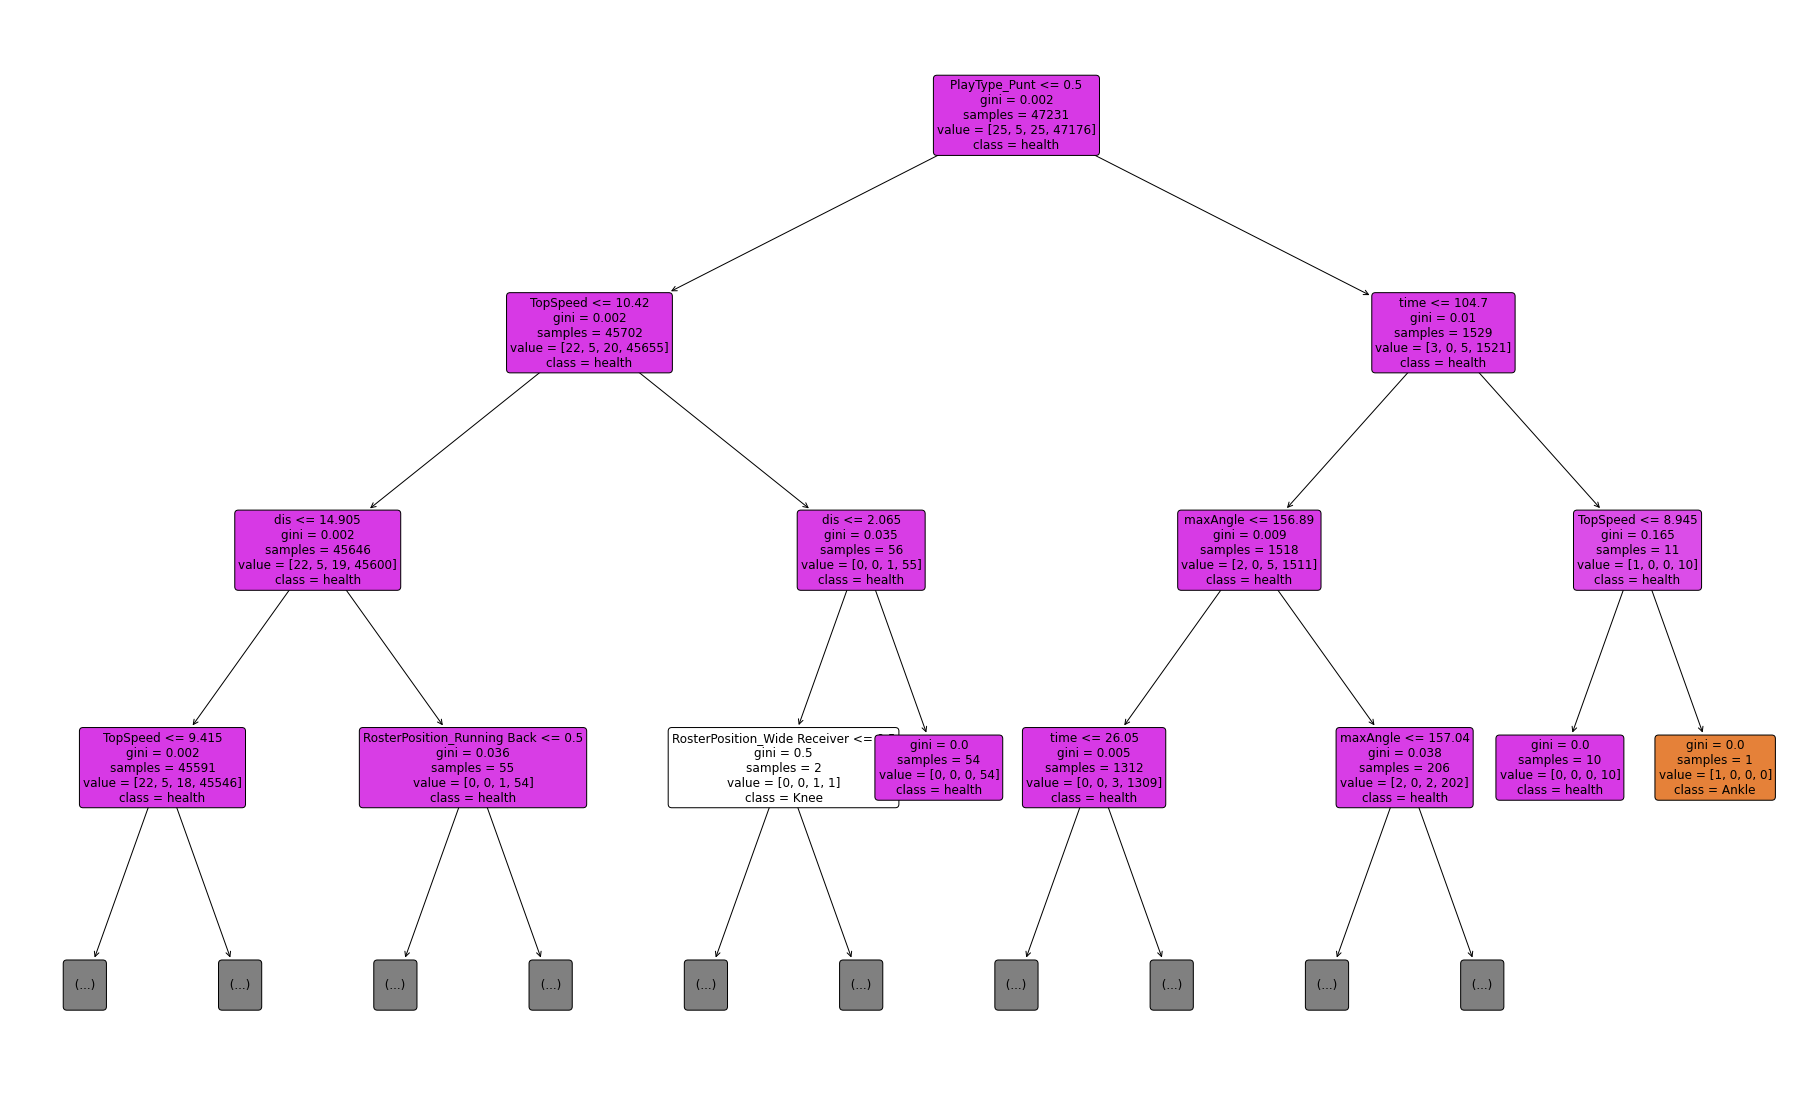

In [18]:
visualize_tree(model1, md=3, fs=(32, 20))

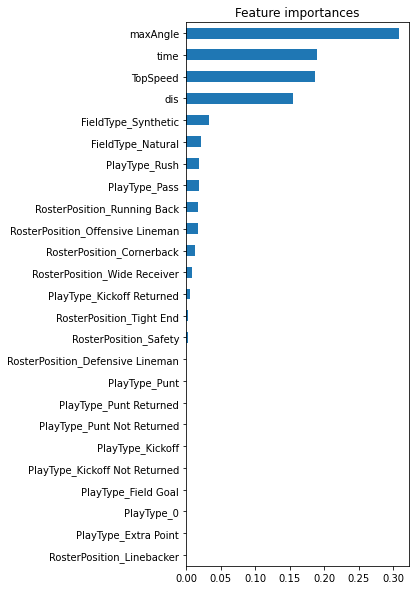

In [7]:
pd.Series(model1.feature_importances_, index=X_train.columns).sort_values()\
    .plot.barh(figsize=(4, 10), rot=0, title='Feature importances')

In [8]:
y_train_pred = pd.DataFrame(model1.predict_proba(X_train), 
                            columns=model1.classes_)

In [9]:
log_loss(y_train, y_train_pred)

2.9978607350820897e-15

In [33]:
y_test_pred = pd.DataFrame(model1.predict_proba(X_test), 
                        columns=model1.classes_)

In [34]:
log_loss(y_test, y_test_pred)

0.08336340847349163

So we have overfitting.

In [9]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit

In [10]:
my_cv = StratifiedShuffleSplit(n_splits=5, train_size=0.7, test_size=0.3)

In [37]:
model1_2 = LogisticRegression(max_iter=10)

In [28]:
-cross_val_score(model1_2, X_train, y_train, cv=my_cv, scoring='neg_log_loss')

array([0.01893969, 0.01840195, 0.01877386, 0.01688808, 0.01589511])

In [11]:
my_param_grid = {'min_samples_leaf': [20, 40, 60],
                 'min_weight_fraction_leaf': [0.01, 0.02, 0.05],
                 'criterion': ['gini', 'entropy'], 
                 'min_impurity_decrease': [1e-5, 1e-6, 1e-7]}

In [12]:
model_gs = GridSearchCV(estimator=model1, 
                           param_grid=my_param_grid, 
                           cv=my_cv, 
                           scoring='neg_log_loss')

In [42]:
model_gs.fit(X_train, y_train)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=None, test_size=0.3,
            train_size=0.7),
             estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'min_impurity_decrease': [1e-05, 1e-06, 1e-07],
                         'min_samples_leaf': [20, 40, 60],
                         'min_weight_fraction_leaf': [0.01, 0.02, 0.05]},
             scoring='neg_log_loss')

In [43]:
model1_3 = model_gs.best_estimator_


In [44]:
-cross_val_score(model1_3, X_train, y_train, cv=my_cv, scoring='neg_log_loss')

array([0.01033612, 0.01033612, 0.01033612, 0.01033612, 0.01033612])

In [ ]:
y_test_pred = pd.DataFrame(model1_3.predict_proba(X_test), 
                           columns=model1_3.classes_)

In [ ]:
log_loss(y_true=y_test, y_pred=y_test_pred)

0.009890981185608957

In [ ]:
y_train_pred = pd.DataFrame(model1_3.predict_proba(X_train), 
                           columns=model1_3.classes_)
log_loss(y_true=y_train, y_pred=y_train_pred)

0.010119017144637922

**Scalling**:

In [20]:
X_train.head()

,time,dis,TopSpeed,maxAngle,FieldType_Natural,FieldType_Synthetic,RosterPosition_Cornerback,RosterPosition_Defensive Lineman,RosterPosition_Linebacker,RosterPosition_Offensive Lineman,...,PlayType_Extra Point,PlayType_Field Goal,PlayType_Kickoff,PlayType_Kickoff Not Returned,PlayType_Kickoff Returned,PlayType_Pass,PlayType_Punt,PlayType_Punt Not Returned,PlayType_Punt Returned,PlayType_Rush
48281,19.2,2.78,7.38,19.62,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
33957,20.3,1.64,1.88,140.50,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
60743,32.1,3.50,7.22,173.50,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
5204,24.3,2.10,3.50,175.25,1,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
36948,29.7,3.78,4.05,59.87,0,1,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [22]:
X2_train = X_train.copy()

In [23]:
X2_train['dis'] = X2_train['dis']*10
X2_train['TopSpeed'] = X2_train['TopSpeed']*10
X2_train.head()

,time,dis,TopSpeed,maxAngle,FieldType_Natural,FieldType_Synthetic,RosterPosition_Cornerback,RosterPosition_Defensive Lineman,RosterPosition_Linebacker,RosterPosition_Offensive Lineman,...,PlayType_Extra Point,PlayType_Field Goal,PlayType_Kickoff,PlayType_Kickoff Not Returned,PlayType_Kickoff Returned,PlayType_Pass,PlayType_Punt,PlayType_Punt Not Returned,PlayType_Punt Returned,PlayType_Rush
48281,19.2,27.8,73.8,19.62,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
33957,20.3,16.4,18.8,140.50,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
60743,32.1,35.0,72.2,173.50,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
5204,24.3,21.0,35.0,175.25,1,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
36948,29.7,37.8,40.5,59.87,0,1,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [48]:
model_gs2 = GridSearchCV(estimator=model1, 
                           param_grid=my_param_grid, 
                           cv=my_cv, 
                           scoring='neg_log_loss')

In [49]:
model_gs2.fit(X2_train, y_train)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=None, test_size=0.3,
            train_size=0.7),
             estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'min_impurity_decrease': [1e-05, 1e-06, 1e-07],
                         'min_samples_leaf': [20, 40, 60],
                         'min_weight_fraction_leaf': [0.01, 0.02, 0.05]},
             scoring='neg_log_loss')

In [50]:
model1_4 = model_gs2.best_estimator_

In [52]:
-cross_val_score(model1_4, X2_train, y_train, cv=my_cv, scoring='neg_log_loss')

array([0.01033612, 0.01033612, 0.01033612, 0.01033612, 0.01033612])

In [54]:
y_test_pred = pd.DataFrame(model1_4.predict_proba(X_test), 
                           columns=model1_4.classes_)

In [55]:
log_loss(y_true=y_test, y_pred=y_test_pred)

0.009890981185608957

So we get the same result.

In [7]:
model2.fit(X_train, y_train)
y_predict = model2.predict(X_test)
print(accuracy_score(y_test,y_predict))
pd.crosstab(y_test,y_predict)

0.9988567073170732


col_0,health
BodyPart,
Ankle,9
Foot,1
Knee,8
health,15726


We can see that we get high accuracy, but the model is not useful because the imbalance data.
So let's try to change the weights.

In [57]:
model2_2 = LogisticRegression(class_weight={'health': 5, 'Knee': 10000, 'Ankle': 10000, 'Foot': 60000})
model2_2.fit(X_train, y_train)

y_predict = model2_2.predict(X_test)
print(accuracy_score(y_test,y_predict))
pd.crosstab(y_test,y_predict)

0.273755081300813


col_0,Ankle,Foot,Knee,health
BodyPart,,,,
Ankle,3,0,5,1
Foot,0,0,1,0
Knee,3,2,2,1
health,5330,3154,2937,4305


In [8]:
model2_3 = LogisticRegression(class_weight='balanced')
model2_3.fit(X_train, y_train)

y_predict = model2_3.predict(X_test)
print(accuracy_score(y_test,y_predict))
pd.crosstab(y_test,y_predict)

0.3041158536585366


col_0,Ankle,Foot,Knee,health
BodyPart,,,,
Ankle,1,1,6,1
Foot,0,0,1,0
Knee,3,3,1,1
health,4566,3432,2942,4786


In [11]:
my_param_grid = {'C': [1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3], 'penalty': ['l1', 'l2']}

In [14]:
lr_model = GridSearchCV(estimator=LogisticRegression(max_iter=10), 
                        param_grid=my_param_grid, 
                        scoring='neg_log_loss', 
                        cv=my_cv)

In [15]:
lr_model.fit(X_train, y_train)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=None, test_size=0.3,
            train_size=0.7),
             estimator=LogisticRegression(max_iter=10),
             param_grid={'C': [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005],
                         'penalty': ['l1', 'l2']},
             scoring='neg_log_loss')

In [16]:
model2_4 = lr_model.best_estimator_


In [17]:
-cross_val_score(model2_4, X_train, y_train, cv=my_cv, scoring='neg_log_loss')

array([0.01861717, 0.01741336, 0.0164866 , 0.01625613, 0.0196356 ])

In [18]:
-lr_model.best_score_

0.01686600835759537

In [21]:
log_loss(y_test, model2_4.predict_proba(X_test))

0.015635460633915334

In [22]:
y_predict = model2_4.predict(X_test)
print(accuracy_score(y_test,y_predict))
pd.crosstab(y_test,y_predict)

0.9988567073170732


col_0,health
BodyPart,
Ankle,9
Foot,1
Knee,8
health,15726


In [9]:
model3.fit(X_train, y_train)
y_predict = model3.predict(X_test)
print(accuracy_score(y_test,y_predict))
pd.crosstab(y_test,y_predict)

0.9988567073170732


col_0,health
BodyPart,
Ankle,9
Foot,1
Knee,8
health,15726


In [22]:
from xgboost import XGBClassifier

In [24]:
model4 = XGBClassifier()

In [25]:
model4.fit(X_train, y_train)

XGBClassifier(objective='multi:softprob')

In [ ]:
-cross_val_score(model4, X_train, y_train, cv=my_cv, scoring='neg_log_loss')

array([0.01065477, 0.01062675, 0.01093086, 0.01017462, 0.01111135])

In [26]:
y_predict = model4.predict(X_test)
print(accuracy_score(y_test,y_predict))
pd.crosstab(y_test,y_predict)

0.9988567073170732


col_0,health
BodyPart,
Ankle,9
Foot,1
Knee,8
health,15726


In [23]:
model5 = XGBClassifier(max_depth=3, subsample=0.8, n_estimators=100, learning_rate=0.1, min_child_weight=1, random_state=5)

In [28]:
model5.fit(X_train, y_train)
-cross_val_score(model5, X_train, y_train, cv=my_cv, scoring='neg_log_loss')

array([0.01092943, 0.01058706, 0.01038936, 0.01048461, 0.01091121])

In [29]:
y_predict = model5.predict(X_test)
print(accuracy_score(y_test,y_predict))
pd.crosstab(y_test,y_predict)

0.9988567073170732


col_0,health
BodyPart,
Ankle,9
Foot,1
Knee,8
health,15726


In [26]:
model5_2 = XGBClassifier(max_depth=3, subsample=0.8, n_estimators=200, learning_rate=0.05, min_child_weight=1, random_state=5)

In [ ]:
model5_2.fit(X_train, y_train)
-cross_val_score(model5_2, X_train, y_train, cv=my_cv, scoring='neg_log_loss')

array([0.01057744, 0.01074852, 0.0109646 , 0.01061083, 0.01065457])

In [ ]:
log_loss(y_test, model5_2.predict_proba(X_test))

0.0102123840231879

In [ ]:
my_param_grid = {'max_depth': [1, 2, 3, 4, 5, 6], 'subsample': [0.6, 0.7, 0.8], 'subsample': [0.6, 0.7, 0.8]\
                 , 'n_estimators': [100, 150, 200], 'learning_rate': [0.05, 0.1, 0.15], 'min_child_weight': [1, 2, 3]}

In [ ]:
XGB_model = GridSearchCV(estimator=XGBClassifier(), 
                        param_grid=my_param_grid, 
                        scoring='neg_log_loss', 
                        cv=my_cv)

In [ ]:
XGB_model.fit(X_train, y_train)

In [ ]:
-XGB_model.best_score_

In [ ]:
log_loss(y_test, XGB_model.predict_proba(X_test))

Now let's try to use "sample" and "smote" to deal with the imcalance data.

In [4]:
data_1 = (df[df['BodyPart']=='health']).sample(100)
data_2 = (df[df['BodyPart']!='health'])
data_3 = pd.concat([data_1, data_2])

In [5]:
data3 = pd.get_dummies(data_3.drop(columns=['Key', 'BodyPart']))

In [6]:
X = data3
y = data_3.BodyPart

X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, 
                                                    train_size=0.75, 
                                                    test_size=0.25, 
                                                    stratify=data_3.BodyPart,
                                                    random_state=4546)

In [8]:
model3.fit(X_train2, y_train2)

y_predict = model3.predict(X_test2)
print(accuracy_score(y_test2,y_predict))
pd.crosstab(y_test2,y_predict)

0.4090909090909091


col_0,Ankle,Knee,health
BodyPart,,,
Ankle,0,1,8
Foot,0,0,2
Knee,1,2,5
health,9,0,16


In [13]:
model_gs = GridSearchCV(estimator=model1, 
                           param_grid=my_param_grid, 
                           cv=my_cv, 
                           scoring='neg_log_loss')

In [15]:
model_gs.fit(X_train2, y_train2)
model6 = model_gs.best_estimator_

In [32]:
y_predict = model6.predict(X_test2)
print(accuracy_score(y_test2,y_predict))
pd.crosstab(y_test2,y_predict)

0.5681818181818182


col_0,health
BodyPart,
Ankle,9
Foot,2
Knee,8
health,25


In [19]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(k_neighbors=3)

In [20]:
X_train_smote, y_train_smote = smote.fit_resample(X_train,y_train)

In [21]:
from collections import Counter
print("Before SMOTE :" , Counter(y_train))
print("After SMOTE :" , Counter(y_train_smote))

Before SMOTE : Counter({'health': 47176, 'Knee': 25, 'Ankle': 25, 'Foot': 5})
After SMOTE : Counter({'health': 47176, 'Knee': 47176, 'Ankle': 47176, 'Foot': 47176})


In [24]:
model5.fit(X_train_smote,y_train_smote)
-cross_val_score(model5, X_train, y_train, cv=my_cv, scoring='neg_log_loss')

array([0.01058609, 0.0110453 , 0.01051364, 0.01056337, 0.01078748])

In [25]:
y_predict = model5.predict(X_test)
print(accuracy_score(y_test,y_predict))
pd.crosstab(y_test,y_predict)

0.9764354674796748


col_0,Ankle,Foot,Knee,health
BodyPart,,,,
Ankle,0,0,0,9
Foot,0,0,0,1
Knee,0,0,0,8
health,69,85,199,15373


In [27]:
model5_2.fit(X_train_smote,y_train_smote)
y_predict = model5_2.predict(X_test)
print(accuracy_score(y_test,y_predict))
pd.crosstab(y_test,y_predict)

0.9736407520325203


col_0,Ankle,Foot,Knee,health
BodyPart,,,,
Ankle,0,0,0,9
Foot,0,0,0,1
Knee,0,0,0,8
health,68,90,239,15329


In [28]:
X_train_smote2, y_train_smote2 = smote.fit_resample(X_train2,y_train2)

In [30]:
from collections import Counter
print("Before SMOTE :" , Counter(y_train2))
print("After SMOTE :" , Counter(y_train_smote2))

Before SMOTE : Counter({'health': 75, 'Ankle': 25, 'Knee': 25, 'Foot': 4})
After SMOTE : Counter({'health': 75, 'Foot': 75, 'Ankle': 75, 'Knee': 75})


In [ ]:
model5_2.fit(X_train_smote2,y_train_smote2)
y_predict = model5_2.predict(X_test2)
print(accuracy_score(y_test2,y_predict))
pd.crosstab(y_test2,y_predict)

0.36363636363636365


col_0,Ankle,Foot,Knee,health
BodyPart,,,,
Ankle,2,0,1,6
Foot,0,0,1,1
Knee,4,0,1,3
health,6,2,4,13


My conclusion is that in case of imbalance data we need to choose what is more important for us correspondingly the business problem.